<h1> MIDS W207 Final</h1>

<h3> Group Members </h3>
Ben Attix <br>
Justin Plumley <br>
Dan Watson

<h3> Kaggle Competition </h3>
Zillow Prize: Zillow’s Home Value Prediction (Zestimate)

<h3> Evaluation </h3>
Submissions are evaluated on Mean Absolute Error between the predicted log error and the actual log error. The log error is defined as:
logerror=log(Zestimate)−log(SalePrice)
and it is recorded in the transactions training data. If a transaction didn't happen for a property during that period of time, that row is ignored and not counted in the calculation of MAE.

<h5> Competition Website </h5>
https://www.kaggle.com/c/zillow-prize-1#description

<h2> Load libraries, data, and test output

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
import time
from matplotlib.ticker import MultipleLocator


# preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline

from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 


# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_df = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
prop_df = pd.read_csv("properties_2016.csv")
print prop_df.shape 
print train_df.shape
#df outputs
#prop_df.head()
#train_df.head()

/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)
(90275, 3)


<H2> EDA </H2> <br>
Many ideas and code taken from following EDA Kernels:
https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize (python)
https://www.kaggle.com/philippsp/exploratory-analysis-zillow (R)
https://www.kaggle.com/captcalculator/a-very-extensive-zillow-exploratory-analysis (R)
https://www.kaggle.com/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity (python)

<H5> Start by looking at the parcelIDs that occur in each dataset </H5>

In [3]:
# start by looing at unique parcelIDs
print "Unique ParcelIDs in train_df:", train_df.parcelid.nunique()
print "Unique ParcelIDs in prop_df:", prop_df.parcelid.nunique()

Unique ParcelIDs in train_df: 90150
Unique ParcelIDs in prop_df: 2985217


We have 2,985,217 parcel IDs in the properties data but only 90,150 in the training data. The only parcel IDs we can use are the ones both datasets, the rest are useless to us.

By doing an inner merge we can limit our data down to the parcel IDs we want.

In [4]:
# merge dataframes and view result
train_df = pd.merge(train_df, prop_df, on='parcelid', how='inner')
print 'Dataframe shape:', train_df.shape
train_df.head()

Dataframe shape: (90275, 60)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [5]:
train_df.describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,9.027500e+04,90275.000000,28781.000000,261.000000,43.000000,90275.000000,90275.000000,16.0,57364.000000,89093.000000,...,95.000000,89519.000000,20570.000000,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,1783.000000,8.967000e+04
mean,1.298466e+07,0.011457,1.816372,7.229885,713.581395,2.279474,3.031869,4.0,5.565407,2.309216,...,311.694737,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,13.402692,6.049151e+13
std,2.504510e+06,0.161079,2.974168,2.716196,437.434198,1.004271,1.156436,0.0,1.900602,0.976172,...,346.354850,23.763475,0.544498,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,2.715966,2.046605e+11
min,1.071174e+07,-4.605000,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,1.000000,...,18.000000,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.000000,6.037101e+13
25%,1.155950e+07,-0.025300,1.000000,7.000000,407.500000,2.000000,2.000000,4.0,4.000000,2.000000,...,100.000000,1953.000000,1.000000,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,13.000000,6.037320e+13
50%,1.254734e+07,0.006000,1.000000,7.000000,616.000000,2.000000,3.000000,4.0,7.000000,2.000000,...,159.000000,1970.000000,1.000000,1.320000e+05,3.428720e+05,2015.0,1.929700e+05,4542.750000,14.000000,6.037615e+13
75%,1.422755e+07,0.039200,1.000000,7.000000,872.000000,3.000000,4.000000,4.0,7.000000,3.000000,...,361.000000,1987.000000,2.000000,2.105345e+05,5.405890e+05,2015.0,3.454195e+05,6901.090000,15.000000,6.059042e+13
max,1.629608e+08,4.737000,13.000000,21.000000,1555.000000,20.000000,16.000000,4.0,12.000000,20.000000,...,1366.000000,2015.000000,4.000000,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,99.000000,6.111009e+13


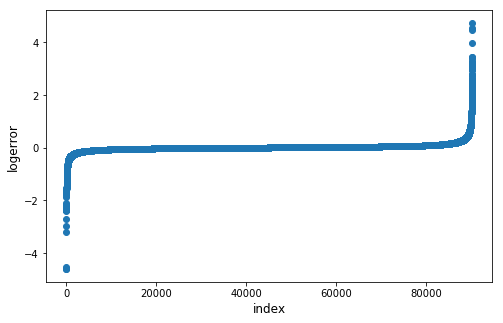

In [7]:
plt.figure(figsize=(8,5))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

Log error is quite good for vast majority- outliers are key here

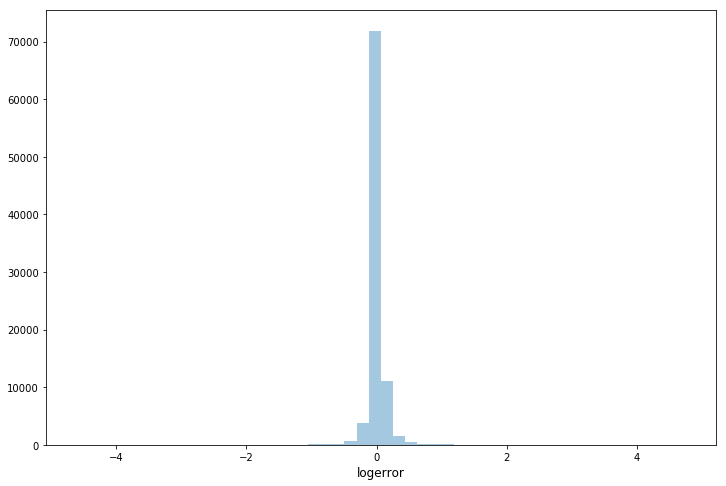

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Seems liked a peaked distribution, but outliers on log error are affecting the histogram.  Removing outliers:

/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


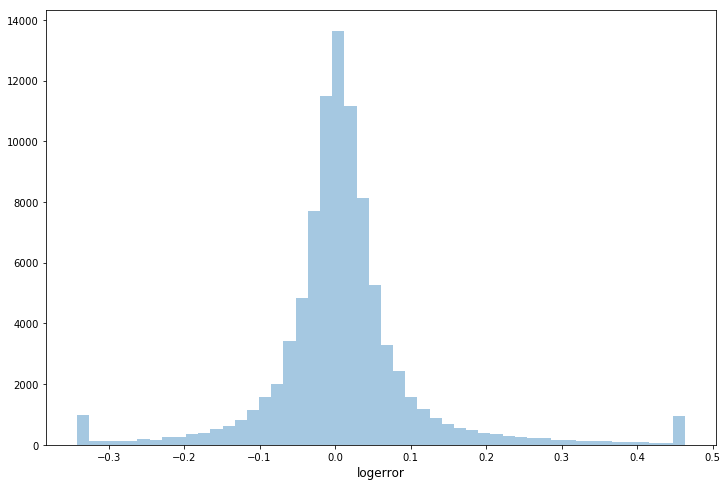

In [5]:
## DECISION NEEDED might this hurt out modeling later?  Should the winsorizing be pushed to a new dataset instead?

# ulimit = np.percentile(train_df.logerror.values, 99)
# llimit = np.percentile(train_df.logerror.values, 1)
# train_df['logerror'].loc[train_df['logerror']>ulimit] = ulimit
# train_df['logerror'].loc[train_df['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Close to a normal distribution.  This shows why our test data of just predicting the mean did fairly ok.



<H5> Transaction Date </H5>

In [10]:
train_df.transactiondate.describe()

count                   90275
unique                    352
top       2016-07-29 00:00:00
freq                      910
first     2016-01-01 00:00:00
last      2016-12-30 00:00:00
Name: transactiondate, dtype: object

All the data is from 2016- we can aggregate it by month

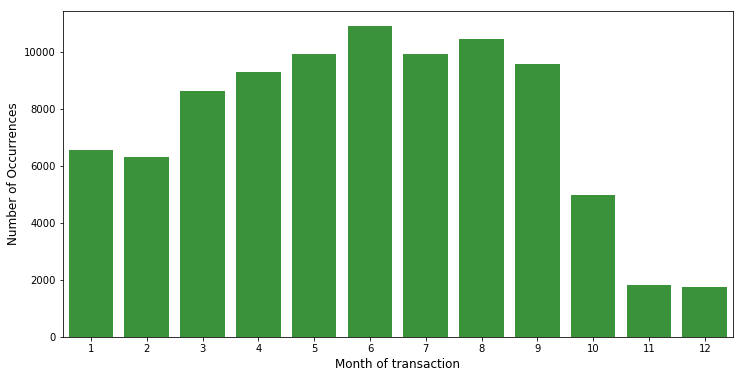

In [6]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
bars= sns.barplot(cnt_srs.index, cnt_srs.values,  color=color[2])
plt.xticks()
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

Slow start of the year, then transactions pick up through August.  We do not have all the transactions after October 15th, per competition website.

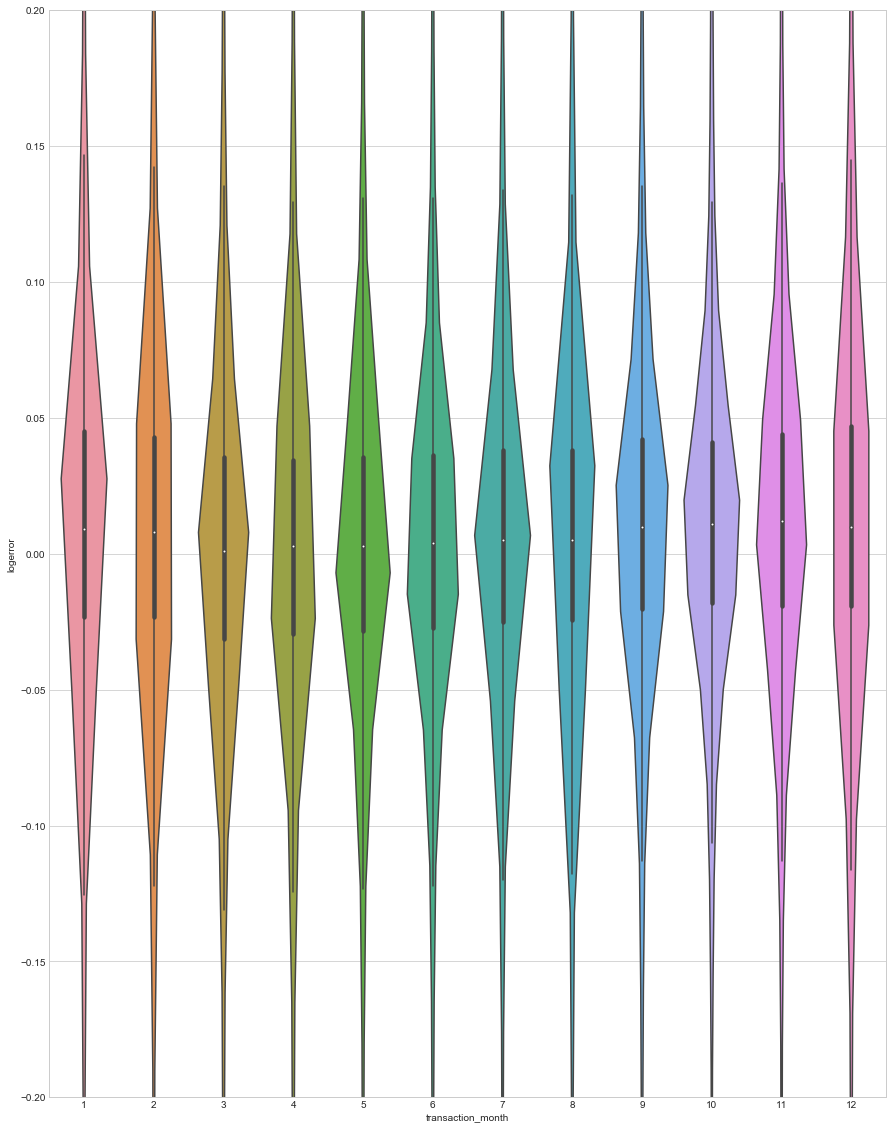

In [7]:
sns.set_style("whitegrid")
s1_dims = (15, 20)
fig, ax = plt.subplots(figsize=s1_dims)
ax.set(ylim=(-0.2, 0.2))
sns.violinplot(ax=ax, data=train_df, x="transaction_month", y="logerror")


Variance appears to grow with the later months (those with fewer values), though the medians appear to be positive, particularly for the winter months.  Besides normal features, we may want to include dummy variables for seasonality.


<h5> Parcel ID </h5>

In [13]:
train_df['parcelid'].value_counts().reset_index()['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

Only 124 of the 90k+ properties had multiple transactions in this year period

<H5> Onto the Properties 2016 file <H5>

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


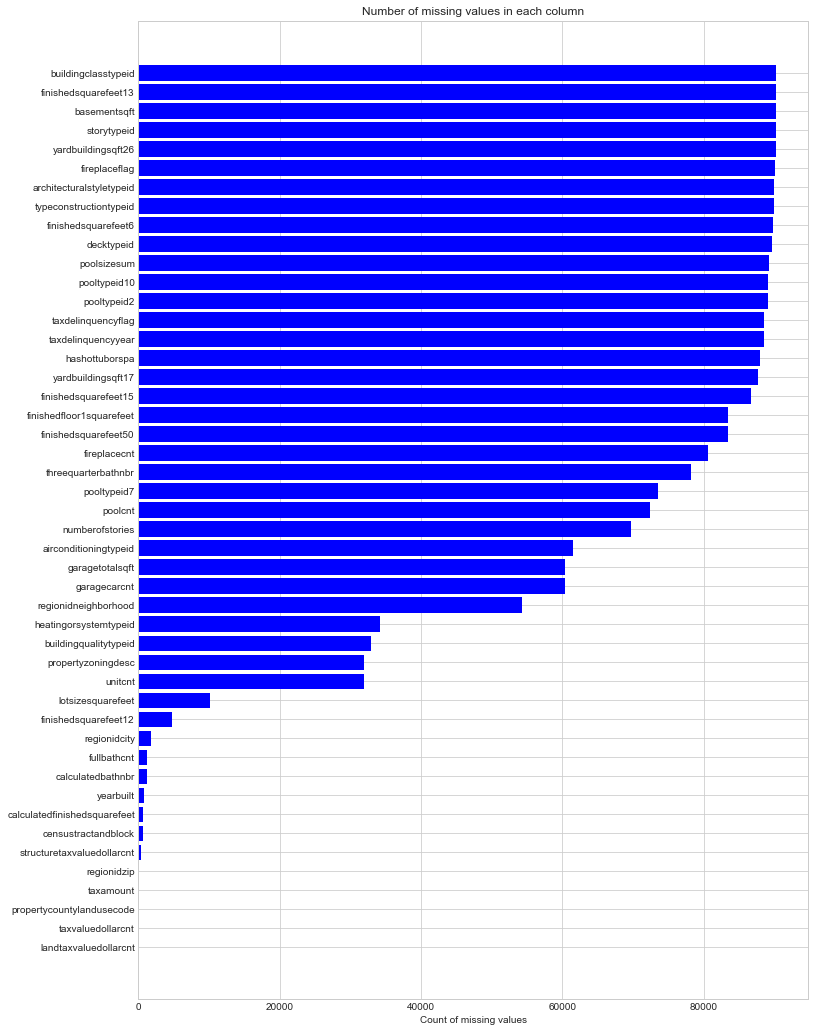

In [8]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [9]:
# How much of your data is missing?
train_df.isnull().sum().sort_values(ascending=False).head()

buildingclasstypeid     90259
finishedsquarefeet13    90242
basementsqft            90232
storytypeid             90232
yardbuildingsqft26      90180
dtype: int64

In [10]:
# df = df.drop('column_name', 1)
to_drop = [ 'parcelid'
           ,'architecturalstyletypeid'
           ,'assessmentyear'
           ,'bathroomcnt'
           ,'buildingclasstypeid'
           ,'decktypeid'
           ,'threequarterbathnbr'
           ,'finishedfloor1squarefeet'
           ,'finishedsquarefeet6'
           ,'finishedsquarefeet12'
           ,'finishedsquarefeet13'
           ,'finishedsquarefeet15'
           ,'finishedsquarefeet50'
           ,'fireplaceflag'
           ,'fullbathcnt'
           ,'garagetotalsqft'
           ,'latitude'
           ,'longitude'
           ,'poolsizesum'
           ,'propertyzoningdesc'
           ,'rawcensustractandblock'
           ,'censustractandblock'
           ,'regionidzip'
           ,'storytypeid'
           ,'typeconstructiontypeid'
           ,'taxvaluedollarcnt'
           ,'taxamount'
           ,'taxdelinquencyyear'
           
           ,'hashottuborspa'
           ,'pooltypeid10'
           ,'pooltypeid2'
           ,'pooltypeid7'
               
           ,'propertycountylandusecode'   # 241 unique values, cannot dummy for size reasons          
           ,'regionidcity'            # 187 unique values, cannot dummy for size reasons
           ,'regionidneighborhood'    # 529 unique values, cannot dummy for size reasons
           ,'transactiondate'
          ]

for col in to_drop:
    train_df = train_df.drop(col,1)

In [11]:
##df['bedroomcnt'] = [0 if x <3 else 1 for x in df['bedroomcnt']] #bad example, but you get the point
# Bin object variables in specific ways

## airconditioningtypeid
train_df['airconditioningtypeid'].fillna(value='missing',inplace=True)

## bedroomcnt
a = np.array(train_df['bedroomcnt'].values.tolist())
train_df['bedroomcnt'] = np.where(a > 6, 6, a).tolist()
train_df['bedroomcnt'].fillna(value=3,inplace=True) # Or maybe impute with most_common, which is 3

## buildingqualitytypeid (best=lowest, worse=highest)

a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'] = np.where(a < 4,  4, a)  #.tolist()
a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'] = np.where(a > 7, 10, a)  #.tolist()
a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'] = np.where(a == 5, 7, a)  #.tolist()
a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'] = np.where(a == 6, 7, a).tolist()
a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'].fillna(value=99,inplace=True) # 99 = missing (BE CAREFUL NOT TO CHANGE BEFORE '>' STATEMENT)

## fips
train_df['fips'].fillna(value=99,inplace=True)

## fireplacecnt
a = np.array(train_df['fireplacecnt'].values.tolist())
train_df['fireplacecnt'] = np.where(a > 3,  3, a)  #.tolist()
train_df['fireplacecnt'].fillna(value=0,inplace=True) #set NaN to zero

## garagecarcnt
a = np.array(train_df['garagecarcnt'].values.tolist())
train_df['garagecarcnt'] = np.where(a > 3,  3, a)  #.tolist()
train_df['garagecarcnt'].fillna(value=99,inplace=True) #set NaN to 99

##  hashottuborspa
#train_df['hashottuborspa'].fillna(value=False,inplace=True) #set NaN to False

## heatingorsystemtypeid
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 19,  14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 21, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 11, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 12, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 10, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a ==  1, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 18, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 13, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 20, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 12, 14, a).tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())

train_df['heatingorsystemtypeid'].fillna(value=99,inplace=True) #set NaN to 99

## numberofstories
a = np.array(train_df['numberofstories'].values.tolist())
train_df['numberofstories'] = np.where(a > 3,  3, a)  #.tolist()
train_df['numberofstories'].fillna(value=99,inplace=True) #set NaN to 99

## poolcnt
train_df['poolcnt'].fillna(value=0,inplace=True) #set NaN to zero

## pooltypes
#train_df['pooltypeid10'].fillna(value=0,inplace=True) #set NaN to zero
#train_df['pooltypeid2'].fillna(value=0,inplace=True) #set NaN to zero
#train_df['pooltypeid7'].fillna(value=0,inplace=True) #set NaN to zero


## propertycountylandusecode
#### probably should loop through, has 241 distinct values, some of which have count=1
#train_df['propertycountylandusecode'].fillna(value=99,inplace=True) #set NaN to 99

## propertylandusetypeid
### too many unique values, so had to drop
train_df['propertylandusetypeid'].fillna(value=99,inplace=True) #set NaN to 99

## regionidcounty
train_df['regionidcounty'].fillna(value=99,inplace=True) #set NaN to 99

## regionidcity
#### probably should loop through, has 187 distinct values, some of which have count=1
### too many unique values, so had to drop
#train_df['regionidcity'].fillna(value=99,inplace=True) #set NaN to 99

## regionidneighborhood
#### probably should loop through, has 500+ distinct values, some of which have count=1.  Maybe use lat-long to KNN???
### too many unique values, so had to drop
#train_df['regionidneighborhood'].fillna(value=99,inplace=True) #set NaN to 99

## calculatedbathnbr
train_df['calculatedbathnbr'].fillna(value=2,inplace=True)  # Or maybe impute with most_common, which is 2

## roomcnt
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt0'] = np.where(a == 0, 1, 0)  #.tolist()
train_df['roomcnt'] = np.where(a < 3,  3, a)  #.tolist()
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt'] = np.where(a > 7, 10, a)  #.tolist()
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt'] = np.where(a == 5, 7, a)  #.tolist()
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt'] = np.where(a == 6, 7, a).tolist()
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt'].fillna(value=6,inplace=True) #set NaN to 6, most common value


## unitcnt
a = np.array(train_df['unitcnt'].values.tolist())
train_df['unitcnt'] = np.where(a > 5, 5, a)  #.tolist()
train_df['unitcnt'].fillna(value=99,inplace=True) #set NaN to 99

## yearbuilt    # BEN - THIS SECTION GAVE ME ERRORS SO I COMMENTED IT OUT
# a = np.array(train_df['yearbuilt'].values.tolist())
# train_df['yearbuilt'] = round(train_df['yearbuilt']/10)
# a = np.array(train_df['yearbuilt'].values.tolist())
# train_df['yearbuilt'] = np.where(a < 190, 189, a)  #.tolist()
# train_df['yearbuilt'].fillna(value=195,inplace=True) #set NaN to 195



##  taxdelinquencyflag   train_df['taxdelinquencyflag'].value_counts()
train_df['taxdelinquencyflag'] = [1 if x == 'Y' else 0 for x in train_df['taxdelinquencyflag']] 
train_df['taxdelinquencyflag'].fillna(value=0,inplace=True) #set NaN to zeroTrue) #set NaN to zero


##  Numeric variables whose NaN we'll set to zero
a = np.array(train_df['basementsqft'].values.tolist())
train_df['basementsqft_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['basementsqft'].fillna(value=0,inplace=True) #set NaN to zero

a = np.array(train_df['calculatedfinishedsquarefeet'].values.tolist())
train_df['calculatedfinishedsquarefeet_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['calculatedfinishedsquarefeet'].fillna(value=0,inplace=True) #set NaN to zero

a = np.array(train_df['lotsizesquarefeet'].values.tolist())
train_df['lotsizesquarefeet_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['lotsizesquarefeet'].fillna(value=0,inplace=True) #set NaN to zero

a = np.array(train_df['yardbuildingsqft17'].values.tolist())
train_df['yardbuildingsqft17_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['yardbuildingsqft17'].fillna(value=0,inplace=True) #set NaN to zero
a = np.array(train_df['yardbuildingsqft17'].values.tolist())
train_df['yardbuildingsqft17'] = np.where(a > 0, 1, 0)  #.tolist()

a = np.array(train_df['yardbuildingsqft26'].values.tolist())
train_df['yardbuildingsqft26_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['yardbuildingsqft26'].fillna(value=0,inplace=True) #set NaN to zero
a = np.array(train_df['yardbuildingsqft26'].values.tolist())
train_df['yardbuildingsqft26'] = np.where(a > 0, 1, 0)  #.tolist()

a = np.array(train_df['structuretaxvaluedollarcnt'].values.tolist())
train_df['structuretaxvaluedollarcnt_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['structuretaxvaluedollarcnt'].fillna(value=0,inplace=True) #set NaN to zero

a = np.array(train_df['landtaxvaluedollarcnt'].values.tolist())
train_df['landtaxvaluedollarcnt_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['landtaxvaluedollarcnt'].fillna(value=10000,inplace=True) #set NaN to 10000

a = np.array(train_df['calculatedfinishedsquarefeet'].values.tolist())
train_df['calculatedfinishedsquarefeet_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['calculatedfinishedsquarefeet'].fillna(value=6000,inplace=True) #set NaN to 6000, most common number



/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in greater


In [ ]:
# Impute missing values using Imputer in sklearn.preprocessing
##from sklearn.preprocessing import Imputer
##imp = Imputer(missing_values='NaN', strategy='median', axis=0)
##imp.fit(X)
##X = pd.DataFrame(data=imp.transform(X) , columns=X.columns)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


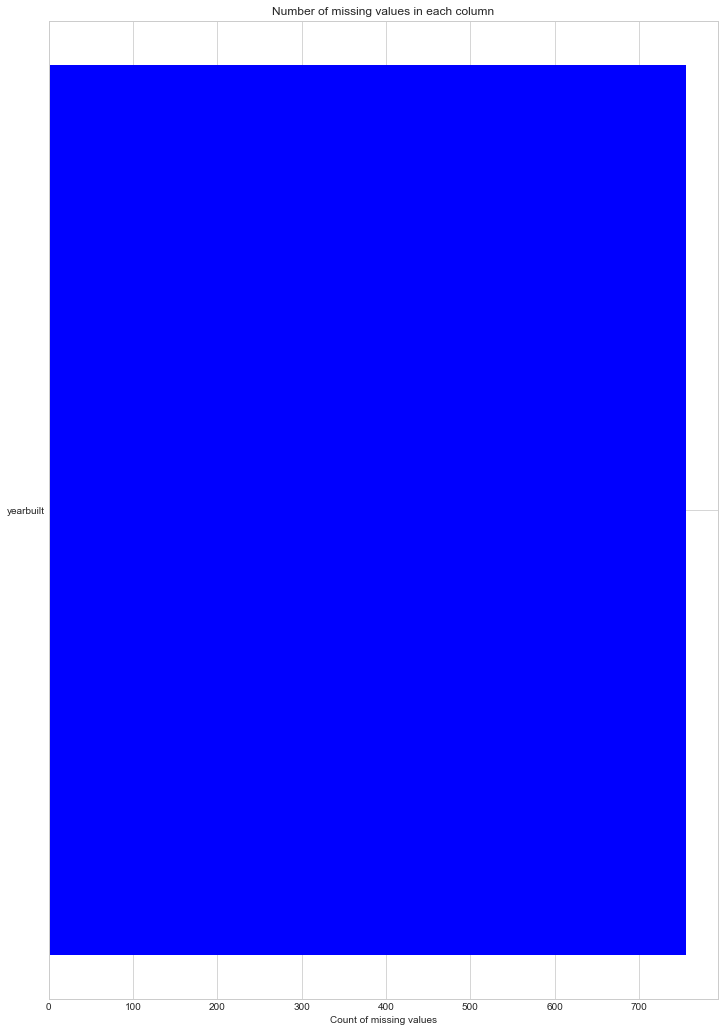

In [12]:
# Check Missing values again, after processing attempt to remove some fields and assign a value to others' NaN values
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [14]:

objs = [ 'airconditioningtypeid'
        ,'bedroomcnt'
        ,'buildingqualitytypeid'
        ,'fips'
        ,'fireplacecnt'
        ,'garagecarcnt'
        ,'heatingorsystemtypeid'
        ,'numberofstories'
        ,'poolcnt'        
        ,'propertylandusetypeid'   
        ,'regionidcounty'
        ,'unitcnt'
        ,'yearbuilt'   
        ,'taxdelinquencyflag'  
        ,'yardbuildingsqft17'
        ,'yardbuildingsqft26'        
        #,'hashottuborspa'
        #,'pooltypeid10'
        #,'pooltypeid2'
        #,'pooltypeid7'
        #,'propertycountylandusecode'  # too many unique values, had to drop
        #,'regionidcity'            # too many unique values, had to drop
        #,'regionidneighborhood'    # too many unique values, had to drop
        ]


for obj in objs:
    train_df[obj] = train_df[obj].astype(object)

In [15]:

flts = [ 'basementsqft'
        ,'calculatedbathnbr'
        ,'calculatedfinishedsquarefeet'
        ,'landtaxvaluedollarcnt'
        ,'lotsizesquarefeet'
        ,'roomcnt'
        ,'structuretaxvaluedollarcnt'
       ]

for flt in flts:
    train_df[flt] = train_df[flt].astype(float)

In [16]:
##OneHotEncoder train_df['storytypeid']

# Decide which categorical variables you want to use in model
for col in train_df.columns:
    if train_df[col].dtypes == 'object':       
        unique_cat = len(train_df[col].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col, unique_cat=unique_cat))

Feature 'airconditioningtypeid' has 7 unique categories
Feature 'bedroomcnt' has 7 unique categories
Feature 'buildingqualitytypeid' has 4 unique categories
Feature 'fips' has 3 unique categories
Feature 'fireplacecnt' has 4 unique categories
Feature 'garagecarcnt' has 5 unique categories
Feature 'heatingorsystemtypeid' has 6 unique categories
Feature 'poolcnt' has 2 unique categories
Feature 'propertylandusetypeid' has 14 unique categories
Feature 'regionidcounty' has 3 unique categories
Feature 'unitcnt' has 6 unique categories
Feature 'yardbuildingsqft17' has 2 unique categories
Feature 'yardbuildingsqft26' has 2 unique categories
Feature 'yearbuilt' has 131 unique categories
Feature 'numberofstories' has 4 unique categories
Feature 'taxdelinquencyflag' has 2 unique categories


In [17]:
# Create dummy list
to_dummy = [ 'airconditioningtypeid'
            ,'bedroomcnt'
            ,'buildingqualitytypeid'
            ,'fips'
            ,'fireplacecnt'
            ,'garagecarcnt'
            ,'heatingorsystemtypeid'
            ,'numberofstories'
            ,'poolcnt'
            ,'propertylandusetypeid'   
            ,'regionidcounty'         
            ,'unitcnt'
            ,'yearbuilt'   
            ,'taxdelinquencyflag'  
            ,'yardbuildingsqft17'
            ,'yardbuildingsqft26'            
            #,'hashottuborspa'
            #,'pooltypeid10'
            #,'pooltypeid2'
            #,'pooltypeid7'            
            #,'propertycountylandusecode'  # 241 unique values, cannot dummy for size reasons                    
#            ,'regionidcity'            # 187 unique values, cannot dummy for size reasons
#            ,'regionidneighborhood'    # 529 unique values, cannot dummy for size reasons            
            ]
            




In [18]:
# Use this function to dummy all the categorical variables we want to keep
def dummy_df(df, todummy_list):
    for x in todummy_list:       
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=True)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [19]:
## bool  
train_df = dummy_df(train_df, to_dummy)

We can clearly see that a lot of these columns are missing data

In [20]:
train_df.dtypes
## Still need to update the dtypes for a smaller dataframe

logerror                            float64
basementsqft                        float64
calculatedbathnbr                   float64
calculatedfinishedsquarefeet        float64
lotsizesquarefeet                   float64
roomcnt                             float64
structuretaxvaluedollarcnt          float64
landtaxvaluedollarcnt               float64
transaction_month                     int64
roomcnt0                              int64
basementsqft_NaN                      int64
calculatedfinishedsquarefeet_NaN      int64
lotsizesquarefeet_NaN                 int64
yardbuildingsqft17_NaN                int64
yardbuildingsqft26_NaN                int64
structuretaxvaluedollarcnt_NaN        int64
landtaxvaluedollarcnt_NaN             int64
airconditioningtypeid_1.0             uint8
airconditioningtypeid_3.0             uint8
airconditioningtypeid_5.0             uint8
airconditioningtypeid_9.0             uint8
airconditioningtypeid_11.0            uint8
airconditioningtypeid_13.0      

In [92]:
# Combine these two provided datasets

# train = train_df.merge(train_df2, how='left', on='parcelid')  # don't need, merge done above

# train = train.drop('transactiondate',1)    # dropped above already

# train_data = train[:2000000]
# dev_data = train[2000000:]
# mini_train_data = train[:20000]


In [21]:
for column in train_df.columns:
    print column, train_df[column].isnull().sum()

logerror 0
basementsqft 0
calculatedbathnbr 0
calculatedfinishedsquarefeet 0
lotsizesquarefeet 0
roomcnt 0
structuretaxvaluedollarcnt 0
landtaxvaluedollarcnt 0
transaction_month 0
roomcnt0 0
basementsqft_NaN 0
calculatedfinishedsquarefeet_NaN 0
lotsizesquarefeet_NaN 0
yardbuildingsqft17_NaN 0
yardbuildingsqft26_NaN 0
structuretaxvaluedollarcnt_NaN 0
landtaxvaluedollarcnt_NaN 0
airconditioningtypeid_1.0 0
airconditioningtypeid_3.0 0
airconditioningtypeid_5.0 0
airconditioningtypeid_9.0 0
airconditioningtypeid_11.0 0
airconditioningtypeid_13.0 0
airconditioningtypeid_missing 0
airconditioningtypeid_nan 0
bedroomcnt_0.0 0
bedroomcnt_1.0 0
bedroomcnt_2.0 0
bedroomcnt_3.0 0
bedroomcnt_4.0 0
bedroomcnt_5.0 0
bedroomcnt_6.0 0
bedroomcnt_nan 0
buildingqualitytypeid_4.0 0
buildingqualitytypeid_7.0 0
buildingqualitytypeid_10.0 0
buildingqualitytypeid_99.0 0
buildingqualitytypeid_nan 0
fips_6037.0 0
fips_6059.0 0
fips_6111.0 0
fips_nan 0
fireplacecnt_0.0 0
fireplacecnt_1.0 0
fireplacecnt_2.0 0
fi

<h2> KNN </h2>

In [31]:
trainknn= train_df.copy()
#['airconditioningtypeid', 'parcelid','taxdelinquencyflag','transactiondate', 'propertycountylandusecode']

ulimit = np.percentile(trainknn.logerror.values, 99)
llimit = np.percentile(trainknn.logerror.values, 1)
trainknn['logerror'].loc[trainknn['logerror']>=ulimit] = 1
trainknn['logerror'].loc[trainknn['logerror']<=llimit] = -1
trainknn['logerror'].loc[(trainknn['logerror']>llimit) & (trainknn['logerror']<ulimit)] = 0

train_np = trainknn.values
Y_knn = train_np[:,0]
Y_knn.flatten()
X_knn =train_np[:,1:]

shuffle = np.random.permutation(np.arange(X_knn.shape[0]))
X_knn, Y_knn = X_knn[shuffle], Y_knn[shuffle]

print('data shape: ', X_knn.shape)
print('label shape: ', Y_knn.shape)

# Set some variables to hold test, dev, and training data.
train_data_knn, train_labels_knn = X_knn[:50000], Y_knn[:50000]
dev_data_knn, dev_labels_knn = X_knn[50000:70000], Y_knn[50000:70000]
test_data_knn, test_labels_knn = X_knn[70000:], Y_knn[70000:]


('data shape: ', (90275, 233))
('label shape: ', (90275,))


In [ ]:
k_values = range(1,20)
for i in k_values:
    #initialize and train the classifier
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(train_data_knn, train_labels_knn.astype(int))
    accuracy= clf.score(dev_data_knn, dev_labels_knn.astype(int))
    predictions = clf.predict(dev_data_knn)
    ## if k = 1, then print the classification report
    if i == 1:
        print("Classification Report for k =" + str(i))
        print(classification_report(dev_labels_knn.astype(int),predictions))
    # For all k values, print the accuracy
    print("K: " + str(i) + " Accuracy: " + str(accuracy))

<h2> ML Start </h2>

In [25]:
# Multiple Regression

train_np = train_df.values
Y = train_np[:,0]
Y.flatten()
X = train_np[:,1:]

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape: ', Y.shape)

# Set some variables to hold test, dev, and training data.
train_data, train_labels = X[:50000], Y[:50000]
dev_data, dev_labels = X[50000:70000], Y[50000:70000]
test_data, test_labels = X[70000:], Y[70000:]

#definite MAE (Mean Absolute Error) function
def MAE(test_labels, predictions):
    values = []
    for i in range(len(test_labels)):
        difference = abs(round(test_labels[i],6) - round(predictions[i],6))
        values.append(difference)
    mean_abs_error = round(sum(values)/len(values),7)
    return mean_abs_error

('data shape: ', (90275, 233))
('label shape: ', (90275,))


## Linear Regression Model

In [26]:
# Initialize model
lm = LinearRegression()
lm.fit(train_data, train_labels)
lm_predict = lm.predict(dev_data)

lm_mae = MAE(dev_labels, lm_predict)
print "Linear Regression gives us a Mean Absolute Error of", lm_mae

Linear Regression gives us a Mean Absolute Error of 0.0699228


## Gradient Boosting

In [37]:
estimators = range(10,40)
lowest_mae = 1
results = []
for i in estimators:
    gboost = GradientBoostingRegressor(n_estimators=i) 
    gboost.fit(train_data, train_labels)
    gboost_predict = gboost.predict(dev_data)

    mae = MAE(dev_labels, gboost_predict)
    results.append(mae)
    
    if mae < lowest_mae:
        lowest_mae = mae
        best_estimator = i
print "Best estimator=%d, MAE=%7.6f" % (best_estimator, lowest_mae)

Best estimator=14, MAE=0.068703


0.068703


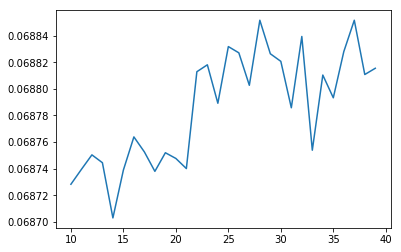

In [38]:
# print(min(results))
plt.plot(estimators, results)

# PCA

In [27]:
pca = PCA(n_components=10)
pca.fit(train_data)
for k in range(1,11):
    explained_var = pca.explained_variance_ratio_[0:k]
    print "k=" + str(k) + ", explained variance =", sum(explained_var)

k=1, explained variance = 0.839686452546
k=2, explained variance = 0.947983610877
k=3, explained variance = 0.999997931193
k=4, explained variance = 0.999999997717
k=5, explained variance = 0.999999999913
k=6, explained variance = 0.999999999949
k=7, explained variance = 0.999999999975
k=8, explained variance = 0.99999999998
k=9, explained variance = 0.999999999983
k=10, explained variance = 0.999999999984


__3 PCA components is probably best. This gives us >99.99% explained variance__

In [31]:
pca = PCA(n_components=3)
pca.fit(train_data)
train_data_pca = pca.transform(train_data) 
dev_data_pca = pca.transform(dev_data) 

estimators = range(1,20)
lowest_mae = 1
results = []
for i in estimators:
    gboost = GradientBoostingRegressor(n_estimators=i) 
    gboost.fit(train_data_pca, train_labels)
    gboost_predict = gboost.predict(dev_data_pca)

    mae = MAE(dev_labels, gboost_predict)
    results.append(mae)
    
    if mae < lowest_mae:
        lowest_mae = mae
        best_estimator = i
print "Best estimator=%d, MAE=%7.6f" % (best_estimator, lowest_mae)

Best estimator=1, MAE=0.069121


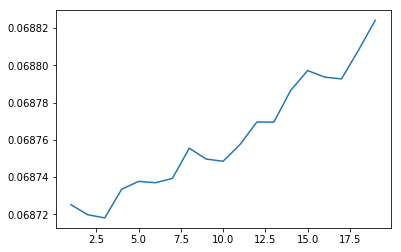

In [50]:
# print(min(results))
plt.plot(estimators, results)

__Using PCA with GradientBoostRegression doesn't help to reduce the MAE. We got 0.068703 before PCA and 0.068718 after. While it doesn't reduce MAE here, maybe it is still better for generalizability? (Maybe not, open to suggestions). PCA also reduced runtime from 20 minutes down to less than 30 seconds.__

In [42]:
spca = SparsePCA(n_components = 10, alpha=0.5, tol=0.001)
spca.fit(train_data)
for k in range(1,11):
    explained_var = pca.explained_variance_ratio_[0:k]
    print "k=" + str(k) + ", explained variance =", sum(explained_var)

k=1, explained variance = 0.826972491026
k=2, explained variance = 0.941827905928
k=3, explained variance = 0.999997994697
k=4, explained variance = 0.999997994697
k=5, explained variance = 0.999997994697
k=6, explained variance = 0.999997994697
k=7, explained variance = 0.999997994697
k=8, explained variance = 0.999997994697
k=9, explained variance = 0.999997994697
k=10, explained variance = 0.999997994697


In [28]:
spca = SparsePCA(n_components = 3, alpha=0.5, tol=0.001)
spca.fit(train_data)
train_data_spca = spca.transform(train_data) 
dev_data_spca = spca.transform(dev_data) 

estimators = range(1,25)
lowest_mae = 1
results = []
for i in estimators:
    gboost = GradientBoostingRegressor(n_estimators=i) 
    gboost.fit(train_data_spca, train_labels)
    gboost_predict = gboost.predict(dev_data_spca)

    mae = MAE(dev_labels, gboost_predict)
    results.append(mae)
    
    if mae < lowest_mae:
        lowest_mae = mae
        best_estimator = i
print "Best estimator=%d, MAE=%7.6f" % (best_estimator, lowest_mae)

Best estimator=1, MAE=0.069144


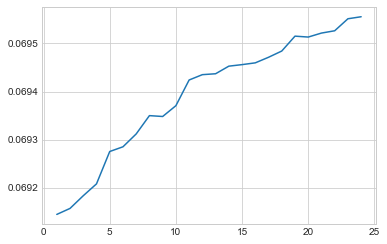

In [29]:
# print(min(results))
plt.plot(estimators, results)

__Using SparcePCA with GradientBoostRegression doesn't help to reduce the MAE either. We got 0.068703 before SparsePCA and 0.068724 after. SparsePCA performed slightly worse than regular PCA (0.068718) as well. The PCA models ran much faster, so maybe they're still useful.__

# Decision Tree Regression

In [32]:
dtr = DecisionTreeRegressor(criterion="mae")
dtr.fit(train_data_pca, train_labels)
dtr_preds = dtr.predict(dev_data_pca)
dtr_mae = MAE(dev_labels, dtr_preds)
print 'DecisionTreeRegressor MAE =', dtr_mae

DecisionTreeRegressor MAE = 0.1157935


# Random Forest Regression

In [ ]:
rfr = RandomForestRegressor(criterion="mae", n_estimators=10)
rfr.fit(train_data_pca, train_labels)
rfr_preds = rfr.predict(dev_data_pca)
mae = MAE(dev_labels, rfr_preds)
print 'RandomForestRegressor MAE =', mae

# Logistic Regression

In [ ]:
# Logistic Regression

LR1 = LogisticRegression(penalty='l2', tol=0.0001, fit_intercept=True, intercept_scaling=1
                              , solver='newton-cg', multi_class='multinomial')
### GridSearchCV to find best C using l2 regularization.  
## Using [float(2**i)/100 for i in range(1,20) ] ...
LR1_para = {'C': [0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24, 20.48, 
                       40.96, 81.92, 163.84, 327.68, 655.36, 1310.72, 2621.44, 5242.88] }
LR1_GS = GridSearchCV(estimator=LR1, param_grid=LR1_para, scoring='f1', n_jobs=-1)
LR1_GS.fit(train_data, train_labels)
print("Start LogisticRegression:")
print(LR1_GS.best_score_)
print(LR1_GS.best_params_)
# print("f1:",metrics.f1_score(dev_labels,LR1_GS.best_estimator_.predict(dev_data),average='micro'))



# General Team notes:
KNN might've not worked before because we already rescaled the logerror so that anything above 99% percentile gets changed to 99% percentile and anything below 1% percentile gets scaled to 1% percentile. Removing this rescaling could make KNN better. I tried doing that, but my KNN runtime was too long so I killed it.

In general, all runtimes are very long (crashing my machine sometimes). I think PCA is really valuable here because it can reduce dimensions and reduce runtimes. For linear regression, regular PCA worked slightly better than SparsePCA.


Since our outcomes variable (logerror) is continuous and not discrete, regressions make more sense than classifiers. Regressions include linear regression, logistic regression (I couldn't get this one to run without errors), Gradient Boost Regression, Decision Tree Regression, and Random Forest Regression (this crashes my machine so badly that it requires reboots). So far, gradient boost has given me the best results (lowest MAE).